# Association Rules - Market Basket Analysis
<br>
<br>


Blackwell Electronics is considering the aquisition of start-up online eletronics retailer ElectronIdex.



Identifying purchasing patterns will provide insights into Electronidex's customer base and could support a decision for or against an aquisition.

There are 3 different data sets about ElectronIdex available that provide information about customers transactions.
<br>
<br>

Version 1.0

Author: Steffen Adolf

Date: 06-27-2019

### Libraries

In [49]:
#loading libraries

library(arules)       
library(arulesViz)
library(lubridate)
library(Amelia)
library(stringr)
library(dplyr)
library(readxl)
library(ggplot2)
library(scales)

### Reading Data

In [3]:
#reading data sets

#order id, date, total price and state of order
orders <- read.csv('orders_translated.csv', sep=";")

#order id, quantity, product type, unit price
line_item <- read.csv('lineitems.csv', sep=";")

#9620 transactions
trans <-read.transactions("trans.csv",sep=",")

#product categories grouping products into higher level
categories <- read_excel("categories.xlsx")

#transaction data without category "Accessories" for further analysis
trans_noAccess <- read.transactions("noaccessories.csv",sep = ",",
                    format("basket"), rm.duplicates = TRUE)

#customer buying patterns of Blackwell for comparison with Electronidex
existing2017 <- read.csv('existingproductattributes2017.csv')

Warning message in asMethod(object):
"removing duplicated items in transactions"

### Data Preparation "order" Data Set

In [4]:
#transforming ID from numerical to character type

orders$id_order <- as.character(orders$id_order)

In [5]:
#missing values

any(is.na(orders))
sum(is.na(orders))

[1] TRUE

[1] 5

In [6]:
#remove observations( onlye 5) with missing values

orders <- na.omit(orders)

In [7]:
#transforming "total_paid" from factor to numeric type

orders$total_paid <- str_trim(orders$total_paid)

orders$total_paid <- gsub(",",".", orders$total_paid)

orders$total_paid <-as.numeric(as.character(orders$total_paid))

In [8]:
#transforming "created_date" from factor to Date-times format

orders$created_date <- str_trim(gsub("Z"," ",orders$created_date))

orders$created_date <- gsub("T"," ",orders$created_date)

orders$created_date <- as.POSIXct(orders$created_date)

### Data Preparation "line_item" Data Set

In [9]:
#removing irrelevant feature "product_id"

line_item <- select(line_item, -product_id)

In [10]:
#removing redundant feature "id"

line_item <- select(line_item, -id)

In [11]:
#transforming "id_order" from numeric to character type

line_item$id_order <- as.character(line_item$id_order)

In [12]:
#transforming "sku" from factor to character 

line_item$sku <- as.character(line_item$sku)

In [13]:
#transforming "date" from factor to date time format

line_item$date <- str_trim(gsub("Z"," ",line_item$date))

line_item$date <- gsub("T"," ",line_item$date)

line_item$date <- as.POSIXct(line_item$date)


In [14]:
#transforming "unit_price" from factor to numeric type

line_item$unit_price <- str_trim(line_item$unit_price)

line_item$unit_price <- gsub(",",".", line_item$unit_price)

line_item$unit_price <-as.numeric(as.character(line_item$unit_price))

In [17]:
#replace 1 observation with negative, illogical "unit_price"

min(line_item$unit_price)

line_item[line_item$unit_price==min(line_item$unit_price),]

line_item$unit_price[line_item$unit_price==-119]<- 99.99

[1] 0

In [19]:
#outlier correction in "unit_price"

max(line_item$unit_price)

line_item[line_item$unit_price==159989.83,]

line_item$unit_price[line_item$unit_price==159989.83] <-159.99

[1] 15349

id_order,product_quantity,sku,date,unit_price


In [20]:
#creating new feature "total_price" 

line_item <- line_item %>% mutate(total_price = product_quantity * unit_price)

In [21]:
#including product categories into data frame, joining by sku as index

categories <- as.data.frame(categories)

line_item <- inner_join(line_item,categories)

Joining, by = "sku"


### Data Preparation "transaction" Data

In [22]:
#replacing names of items with product categories

transNames <- trans@itemInfo 

names(transNames)

names(categories)

names(transNames) <- c("sku")

[1] "labels"

[1] "sku"               "manual_categories"

In [23]:
#join data frames and replace index column with new names

joint_data <- left_join(transNames,categories)

Joining, by = "sku"


In [24]:
#adding new level to transaction data

trans@itemInfo$complete <- joint_data$manual_categories

categories_transactions <- aggregate(trans, itemInfo(trans)[["complete"]])

### Data Exploration

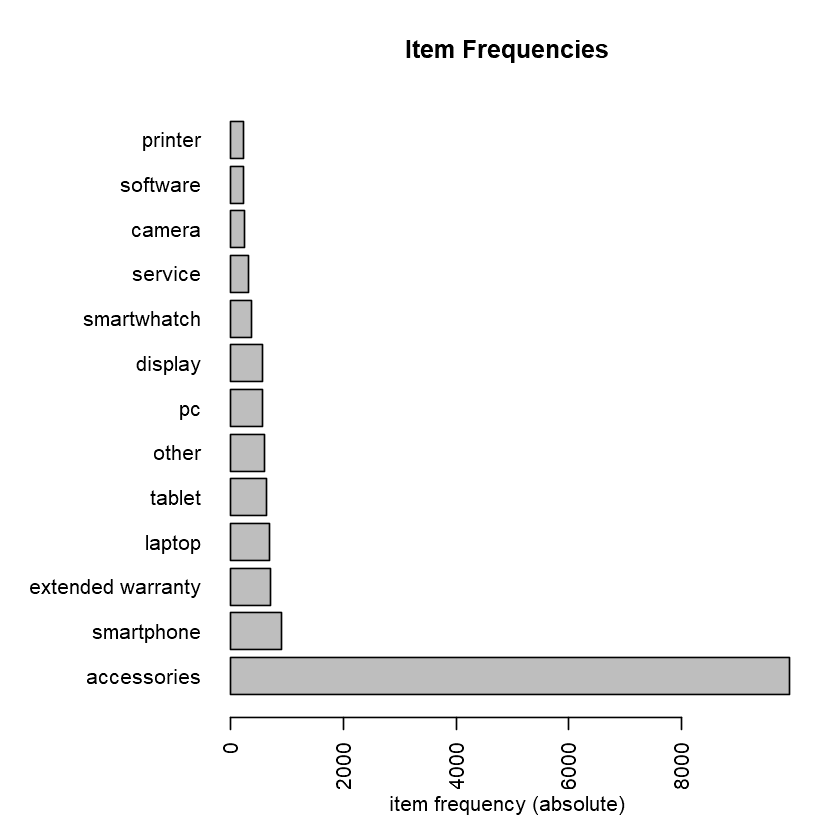

In [25]:
#epxloring transactions

trans1 <- categories_transactions

itemFrequencyPlot(trans1, topN = 13, type = "absolute", main = "Item Frequencies", horiz = TRUE)

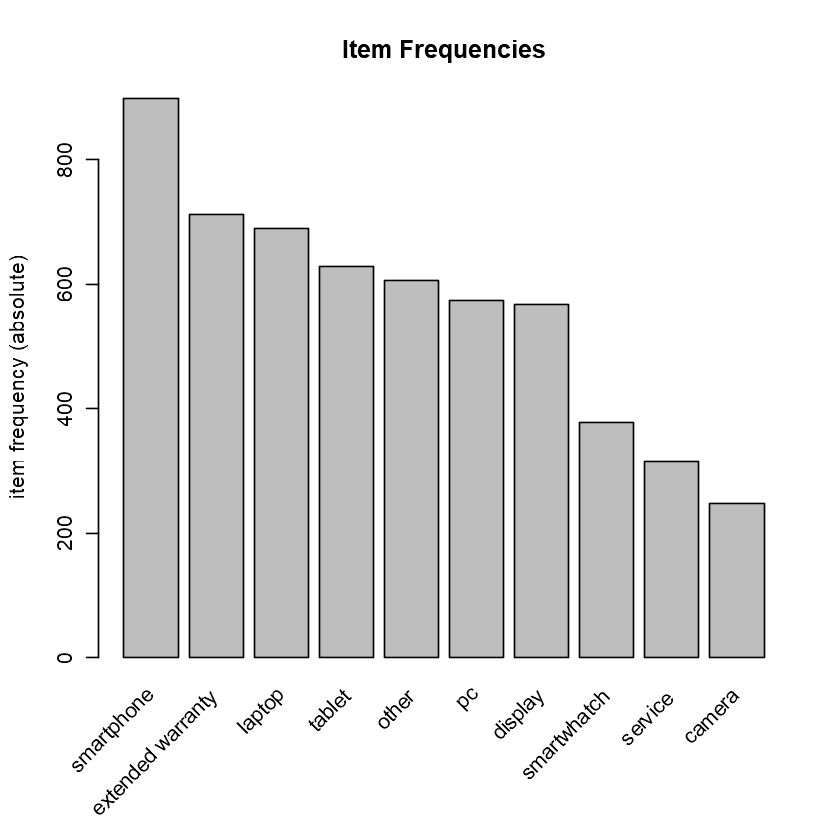

In [26]:
#exploring transaction data without "accessories"

itemFrequencyPlot(trans_noAccess, topN = 10, type = "absolute", 
                main = "Item Frequencies", horiz = FALSE)

Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0.9    0.1    1 none FALSE            TRUE       5    0.02      1
 maxlen target   ext
     12  rules FALSE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 209 

set item appearances ...[0 item(s)] done [0.00s].
set transactions ...[12 item(s), 10454 transaction(s)] done [0.00s].
sorting and recoding items ... [12 item(s)] done [0.00s].
creating transaction tree ... done [0.00s].
checking subsets of size 1 2 3 done [0.00s].
writing ... [11 rule(s)] done [0.00s].
creating S4 object  ... done [0.00s].
     lhs                             rhs                 support    confidence
[1]  {extended warranty,software} => {pc}                0.02018366 0.9859813 
[2]  {extended warranty,other}    => {pc}                0.02008800 0.9459459 
[3]  {software}                   => {pc}        

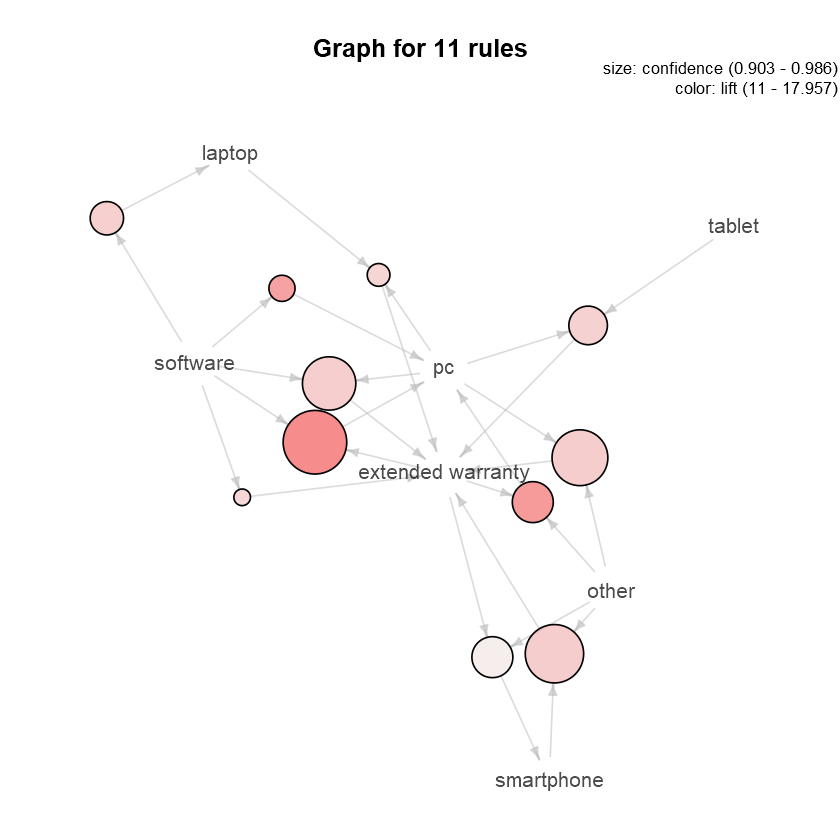

In [29]:
#creating transaction rules with apriori function

rules <- apriori(trans_noAccess, parameter = list(support = 0.02,
            confidence = 0.9, maxlen = 12))

inspect (head(sort(rules, by= "lift"),10))

plot(rules, method="graph",measure = "confidence", shading = "lift")

### Data Exploration - 

#### Comparing revenue and importance of product categories

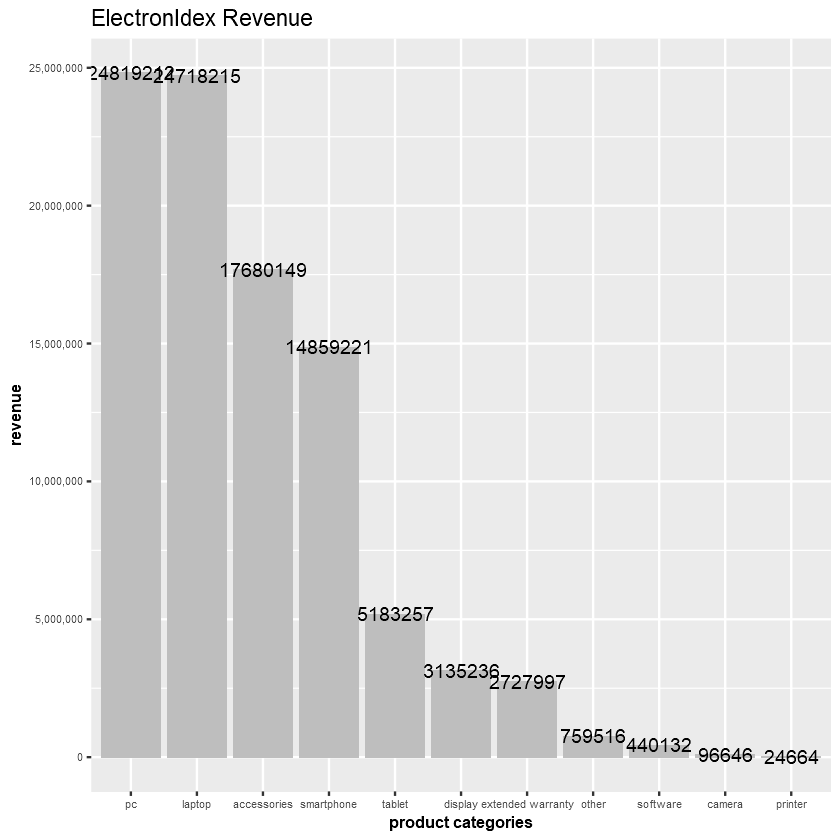

In [65]:
#data preparation for visualisations

g_line <- line_item %>% group_by(manual_categories) %>% summarise(sum = sum(total_price))

g_line <- as.data.frame(g_line)

#excluding irrelevant columns

g_line <- g_line[-c(11,9),]

g_line$sum <- round(g_line$sum)

#sorting factors for visualisation

g_line$manual_categories <- factor(g_line$manual_categories, 
                                   levels = g_line$manual_categories[order(-g_line$sum)])

ggplot(g_line, aes(x = g_line$manual_categories, y = g_line$sum)) + 
  geom_bar(stat = "identity",fill = "grey") + 
  scale_y_continuous(name="revenue",labels = comma) + 
  scale_x_discrete(name = "product categories") +
  geom_text(aes(label = g_line$sum)) + 
  ggtitle("ElectronIdex Revenue") + 
  theme(axis.text=element_text(size=6),
        axis.title=element_text(size=9,face="bold"))




In [46]:
#revenue of Blackwell

revenues <- existing2017

revenues <- revenues[,c(1,3,18)]

revenues <- mutate(revenues, revenue = Price * Volume)

revenues <- revenues[,c(1,4)]


In [47]:
#grouping data frame by product categories

g_revenue <-
  revenues %>% group_by(ProductType) %>% summarise(sum = sum(revenue))

g_revenue <- as.data.frame(g_revenue)

g_revenue$sum <- round(g_revenue$sum)

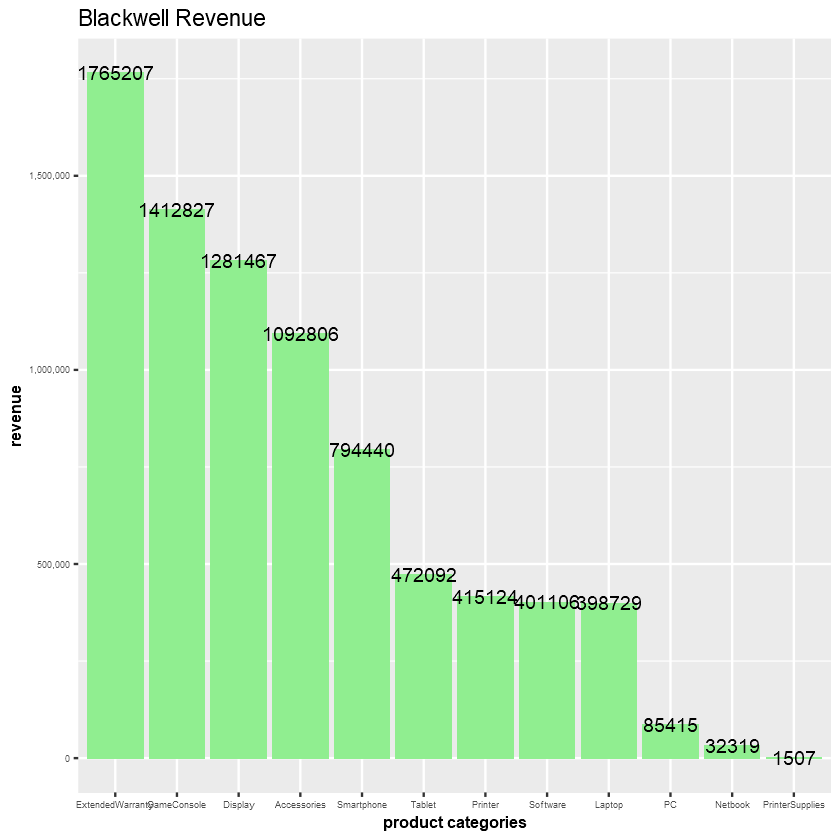

In [69]:
#sorting factors for visualisation

g_revenue$ProductType <- factor(g_revenue$ProductType, 
                                levels = g_revenue$ProductType[order(-g_revenue$sum)])


ggplot(g_revenue, aes(x = g_revenue$ProductType, y = g_revenue$sum))+
    geom_bar(stat = "identity",fill = "light green") +
    scale_y_continuous(name="revenue",labels =comma)+
    scale_x_discrete(name = "product categories")+
    geom_text(aes(label = g_revenue$sum))+
    ggtitle("Blackwell Revenue") +
    theme(axis.text=element_text(size=5),
          axis.title=element_text(size=9,face="bold"))